In [1]:
# import necessary packages for geospatial analysis and data processing

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

print("Packages imported successfully!")

Packages imported successfully!


In [2]:
# Osprey nests data
osprey_nests_df = pd.read_excel('CapstoneData/Osprey Data, Confirmed Nests as of 8.2.2023.xlsx', sheet_name='Outages, 2018-Current')

# Convert pandas DataFrame to GeoDataFrame
osprey_nests_df = gpd.GeoDataFrame(osprey_nests_df, geometry=gpd.points_from_xy(osprey_nests_df.faultlongitude, osprey_nests_df.faultlatitude))

# Outages data
outages_df = gpd.read_file('CapstoneData/Outages01012020through09012023.csv')

# Confirmed nests data
osprey_confirmed_nests = pd.read_excel('CapstoneData/Osprey Data, Confirmed Nests as of 8.2.2023.xlsx', sheet_name='Confirmed Osprey Nests')

# Map data
map_data = gpd.read_file('CapstoneData/NY_Waterbody_List.geojson')


In [3]:
# remove rows from outages_df where 'CauseDesc' is 'Animal - Bird Contact'
outages_df = outages_df[outages_df.CauseDesc != 'Animal - Bird Contact']

In [4]:
outages_df.shape

(175523, 93)

In [5]:
grouped_outages = outages_df.groupby('OPCO')

# Create separate DataFrames for each group
outages_by_opco = {opco: group for opco, group in grouped_outages}

outages_nyseg = outages_df[outages_df.OPCO=='NYSEG']
outages_rge = outages_df[outages_df.OPCO=='RGE']
outages_cmp = outages_df[outages_df.OPCO=='CMP']
outages_ui = outages_df[outages_df.OPCO=='UI']

outages_ui

,OPCO,Incident,IncSeqNo,OPCOIncStartNo,GroupNo,MalfStartDate,MalfStartTime,MalfEndDate,MalfEndTime,Duration,...,faultlongitude,ServiceCenter,ECC_OperatorLog,ThirdPartyAttacher,UI_TREE_CONTACT_TYPE_DESC,FaultFlocAlgoSource,DerivedFaultCircuit,WeatherIndex,iCDSOutageRemark,geometry
0,UI,202302298,1,672804,NULL,9/1/2023,11:31:00,9/1/2023,11:46:33,0.259166667,...,-73.121153,NULL,NULL,NULL,NULL,FuzzyDistPUB_Poles,3540,26,NULL,None
1,UI,202302271,1,672773,NULL,9/1/2023,0:19:30,9/1/2023,5:05:18,4.763333333,...,NULL,NULL,NULL,NULL,NULL,NULL,1543,NULL,NULL,None
6,UI,202302272,1,672805,NULL,9/1/2023,11:37:35,9/1/2023,12:25:30,0.798611111,...,-73.092755,NULL,NULL,NULL,NULL,FuzzyDistPUB_Poles,3648,NULL,NULL,None
10,UI,202302273,1,672816,NULL,9/1/2023,16:20:28,9/1/2023,17:36:50,1.272777778,...,-73.081062,NULL,NULL,NULL,NULL,SinglePolePerCircuitSQL,3677,24,NULL,None
58,UI,202302263,1,672770,NULL,8/31/2023,22:37:23,9/1/2023,0:37:00,1.993611111,...,-72.84408,NULL,NULL,NULL,NULL,FuzzyDistPUB_Poles,1759,23,NULL,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176931,UI,202000012,1,260882,NULL,1/2/2020,21:51:23,1/2/2020,22:00:00,0.143611111,...,-72.93031,Open Event,NULL,NULL,NULL,FuzzyDistPUB_Poles,1530,23,NULL,None
176968,UI,202000004,1,260873,NULL,1/1/2020,20:33:19,1/1/2020,21:29:30,0.936388889,...,-73.202317,Open Event,NULL,NULL,NULL,SinglePolePerCircuitSQL,2500,40,NULL,None
176972,UI,202000001,1,260870,NULL,1/1/2020,7:15:53,1/1/2020,9:58:00,2.701944444,...,-73.177091,Open Event,NULL,NULL,NULL,FuzzyDistPUB_Poles,2545,45,NULL,None
176976,UI,202000002,1,260871,NULL,1/1/2020,7:30:54,1/1/2020,8:37:27,1.109166667,...,-72.969962,Open Event,NULL,NULL,NULL,SinglePolePerCircuitSQL,1606,44,NULL,None


In [6]:
#  only choose columns 'OPCO', 'CustomerCount', CircuitVoltage', 'Division', 'CauseDesc', 'faultlatitude', 'faultlongitude' from outages_cmp
outages_ui = outages_ui[['OPCO', 'CustomerCount', 'CircuitVoltage', 'Division', 'CauseDesc', 'faultlatitude', 'faultlongitude']]
# Filter out records with missing longitude or latitude values
outages_ui = outages_ui[(outages_ui['faultlongitude'] != '') & (outages_ui['faultlatitude'] != '')]
# Replace empty strings with NaN
outages_ui['faultlongitude'] = outages_ui['faultlongitude'].replace('', np.nan)
outages_ui['faultlatitude'] = outages_ui['faultlatitude'].replace('', np.nan)

outages_ui['faultlongitude'] = outages_ui['faultlongitude'].replace('NULL', np.nan)
outages_ui['faultlatitude'] = outages_ui['faultlatitude'].replace('NULL', np.nan)

# Drop rows with NaN values
outages_ui = outages_ui.dropna(subset=['faultlongitude', 'faultlatitude'])

outages_ui.shape

(15871, 7)

In [7]:
outages = outages_ui

In [8]:
grouped_nests = osprey_nests_df.groupby('OPCO')

# Create separate DataFrames for each group
osprey_nests_by_opco = {opco: group for opco, group in grouped_nests}

nests_nyseg = osprey_nests_df[osprey_nests_df.OPCO=='NYSEG']
nests_rge = osprey_nests_df[osprey_nests_df.OPCO=='RGE']
nests_cmp = osprey_nests_df[osprey_nests_df.OPCO=='CMP']
nests_ui = osprey_nests_df[osprey_nests_df.OPCO=='UI']

In [9]:
osprey_nests = nests_ui

In [10]:
# only choose columns 'CauseDesc', 'Division', 'CustomerCount', 'OPCO','faultlatitude','faultlongitude' from osprey_nests
osprey_nests = osprey_nests[['CauseDesc', 'Division', 'CustomerCount', 'OPCO','faultlatitude','faultlongitude']]
# Filter out records with missing longitude or latitude values
osprey_nests = osprey_nests[(osprey_nests['faultlongitude'] != '') & (osprey_nests['faultlatitude'] != '')]
# Replace empty strings with NaN
osprey_nests['faultlongitude'] = osprey_nests['faultlongitude'].replace('', np.nan)
osprey_nests['faultlatitude'] = osprey_nests['faultlatitude'].replace('', np.nan)
# Drop rows with NaN values
osprey_nests = osprey_nests.dropna(subset=['faultlongitude', 'faultlatitude'])

osprey_nests.shape

(1762, 6)

In [11]:
# Create geometry columns for outages and osprey nests datasets using the longitude and latitude
outages['geometry'] = gpd.points_from_xy(pd.to_numeric(outages.faultlongitude, errors='coerce'), pd.to_numeric(outages.faultlatitude, errors='coerce'))
osprey_nests['geometry'] = gpd.points_from_xy(pd.to_numeric(osprey_nests.faultlongitude, errors='coerce'), pd.to_numeric(osprey_nests.faultlatitude, errors='coerce'))

In [12]:
from shapely.geometry import Point

# Convert pandas DataFrame to GeoDataFrame
outages = gpd.GeoDataFrame(outages, geometry=gpd.points_from_xy(outages.faultlongitude, outages.faultlatitude))
osprey_nests = gpd.GeoDataFrame(osprey_nests, geometry=gpd.points_from_xy(osprey_nests.faultlongitude, osprey_nests.faultlatitude))

In [13]:
# Ensure data is using the correct coordinate reference system (CRS)
outages = outages.set_crs(epsg=4326)
osprey_nests = osprey_nests.set_crs(epsg=4326)

In [14]:
import geopandas as gpd
from shapely.geometry import Point
from multiprocessing import Pool
# buffer needs to be in correct coordinate reference system. it is typically calculated in m on the backend, so doing an
# osprey_nests.to_crs(crs=3857) should remove the first warning.
osprey_nests_m = osprey_nests.to_crs(crs=3857)
outages = outages.to_crs(crs=3857)
osprey_buffer = osprey_nests_m.buffer(distance=5000)
print('done')
osprey_buffer_df = gpd.GeoDataFrame(geometry=osprey_buffer)
print(osprey_buffer_df.shape)
print(outages.shape)

# Assume you have a function for the spatial join
def spatial_join_chunk(chunk):
    return gpd.sjoin(chunk['outages'], chunk['osprey_buffer_df'], how='inner', predicate='intersects')
arg = {'outages':outages,'osprey_buffer_df':osprey_buffer_df}

# change coordinates back to original crs
outages_near_nests = spatial_join_chunk(arg).to_crs(crs=4326)
print(outages_near_nests)

done
(1762, 1)
(15871, 8)
       OPCO CustomerCount CircuitVoltage Division          CauseDesc  \
0        UI             1            240       UI  Connector Failure   
6        UI             7          13800       UI       Bird Contact   
336      UI             1            240       UI  Connector Failure   
420      UI             1            240       UI       Tree Contact   
482      UI             1            240       UI  Connector Failure   
...     ...           ...            ...      ...                ...   
172338   UI             1            240       UI  Connector Failure   
172586   UI             1          13800       UI       Tree Contact   
172995   UI             1            240       UI  Connector Failure   
173385   UI             1            240       UI  Connector Failure   
174431   UI             1            240       UI  Connector Failure   

       faultlatitude faultlongitude                    geometry  index_right  
0          41.244386     -73.1

In [15]:
outages_distance_to_water = pd.read_csv('CapstoneData/outages_with_waterbody_distances_CMP.csv')

In [16]:
# remove rows from outages_distance_to_water where 'CauseDesc' is 'Animal - Bird Contact'
outages_distance_to_water = outages_distance_to_water[outages_distance_to_water.CauseDesc != 'Animal - Bird Contact']

In [17]:
outages_distance_to_water['nearest_waterbody_distance_km'].describe()

count    66003.000000
mean         2.833505
std          1.879110
min          0.015773
25%          1.494414
50%          2.402997
75%          3.700646
max         14.649700
Name: nearest_waterbody_distance_km, dtype: float64

In [18]:
# Convert latitude and longitude columns to a GeoDataFrame
outages_distance_to_water['geometry'] = gpd.GeoSeries(
    [Point(xy) for xy in zip(outages_distance_to_water['faultlongitude'], outages_distance_to_water['faultlatitude'])]
)

In [23]:
# Define categories based on conditions
outages_distance_to_water['near_water'] = np.where(outages_distance_to_water['nearest_waterbody_distance_km'] <= 2, 'NW', 'AW')
outages_distance_to_water['near_nest'] = np.where(outages_distance_to_water.index.isin(outages_near_nests.index), 'NN', 'AN')
print(outages_distance_to_water['near_water'].value_counts())
print(outages_distance_to_water['near_nest'].value_counts())

# Assign risk labels based on the desired categories
def assign_risk_label(row):
    if row['near_water'] == 'NW' and row['near_nest'] == 'AN':
        return 'High'
    elif (row['near_water'], row['near_nest']) in [('NW', 'NN'), ('AW', 'AN')]:
        return 'Medium'
    else:
        return 'Low'

outages_distance_to_water['risk'] = outages_distance_to_water.apply(assign_risk_label, axis=1)


AW    39814
NW    26189
Name: near_water, dtype: int64
AN    61313
NN     4690
Name: near_nest, dtype: int64


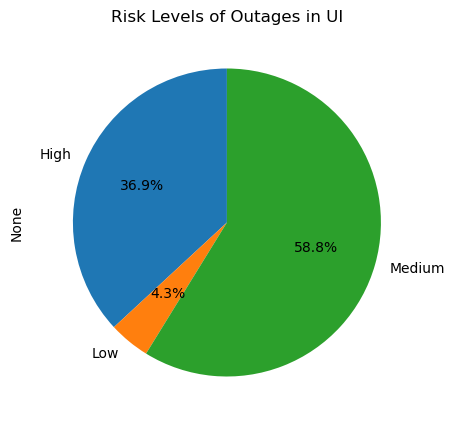

Medium    38806
High      24348
Low        2849
Name: risk, dtype: int64


In [24]:
# create pie chart for risk levels
import matplotlib.pyplot as plt

risk_levels = outages_distance_to_water.groupby('risk').size()
risk_levels.plot.pie(y='risk', figsize=(5, 5), autopct='%1.1f%%', startangle=90, title='Risk Levels of Outages in UI')
plt.show()

# Count the number of confirmed osprey nests in each risk category
confirmed_nests_risk_counts = outages_distance_to_water['risk'].value_counts()
print(confirmed_nests_risk_counts)

In [25]:
# convert outages_distance_to_water to csv
outages_distance_to_water.to_csv('CapstoneData/risk_categories_UI.csv', index=False)